# Overview

As someone with great enthusiasm for the outdoors, living in the DFW area of Texas isn't ideal for me. I want to move to a smaller town with greater access to hiking, biking, and winter recreation. It can be overwhelming to look for places to live in the US: according to my own work below, there are over 30,000 cities recognized by the US Census Bureau. My plan is to collect information about these cities using the [US Census Bureau API](https://api.census.gov/data.html), cluster them using K-Means and agglomerative (hierarchical) clustering, and use the clusters to recommend similar places to live. My work will culminate in a streamlit app that allows users to see similar cities to their selection and filter the results.

Please note: because I kept getting timed out by the US Census Bureau API, this study focuses on cities from 5 states: Texas, Idaho, Wyoming, Colorado, and Utah. I was still able to gather ~3,000 records for the project, which is adequate for the modeling I will perform.

Further information about the data collected: I pulled data from the most recent ACS 5-Year survey tables (2023). These included the data profiles and subject tables. These tables can be found by navigating to the link provided in the previous paragraph.

In [1]:
#imports
import pandas as pd

import helper

# EDA

I'll read in and offer a look at the first few rows of the data. After acquiring and cleaning up the data a bit, I'm left with just under 2,000 rows of data. The acquisition process has been offloaded to the helper.py file, but I will summarize the steps here:
- Acquired info about the states I want to investigate
- Acquired a list of all cities in the US
- Did a merge to limit the cities to the states of interest
- Acquired the feature information (data dictionary below)
- Concatenated the features to the limited cities to create the dataset
- Cleaned up column names and dropped incomplete records

In [2]:
df = pd.read_csv('curated_data.csv')
df.head()

,City,State,Population,Percent employed,Occupation (MBSA),Occupation (S),Occupation (SO),Occupation (RCM),Occupation (PT),Median household income,Homeownership rate,Median home price,Median rent
0,"Acres Green, Colorado",Colorado,2709.0,72.7,61.9,11.9,12.5,8.5,5.2,115536.0,77.4,540000.0,2663.0
1,"Aetna Estates, Colorado",Colorado,1177.0,72.4,12.5,27.3,31.8,17.0,11.4,63887.0,34.3,58200.0,1490.0
2,"Akron, Colorado",Colorado,1681.0,55.4,40.5,19.3,21.5,13.2,5.5,59470.0,70.4,186500.0,1070.0
3,"Alamosa, Colorado",Colorado,9847.0,61.8,34.7,20.7,26.5,6.6,11.4,46969.0,43.8,200200.0,881.0
4,"Alamosa East, Colorado",Colorado,1404.0,68.4,34.9,29.7,17.9,9.1,8.4,44741.0,68.5,219100.0,1100.0


Data dictionary:
| Metric | Code | Value |
| ------ | ---- | ----- |
| Total population | B01003_001E | Estimate |
| Employment | DP03_0002PE | Percentage |
| Occupation (business, science, arts) | DP03_0027PE | Percentage |
| Occupation (service industry) | DP03_0028PE | Percentage |
| Occupation (sales and office) | DP03_0029PE | Percentage |
| Occupation (natural resources, construction, maintenance) | DP03_0030PE | Percentage |
| Occupation (production, transportation) | DP03_0031PE | Percentage |
| Median household income | DP03_0062E | Estimate |
| Homeownership | DP04_0046PE | Percentage |
| Median home price | DP04_0089E | Estimate |
| Median rent | DP04_0134E | Estimate |

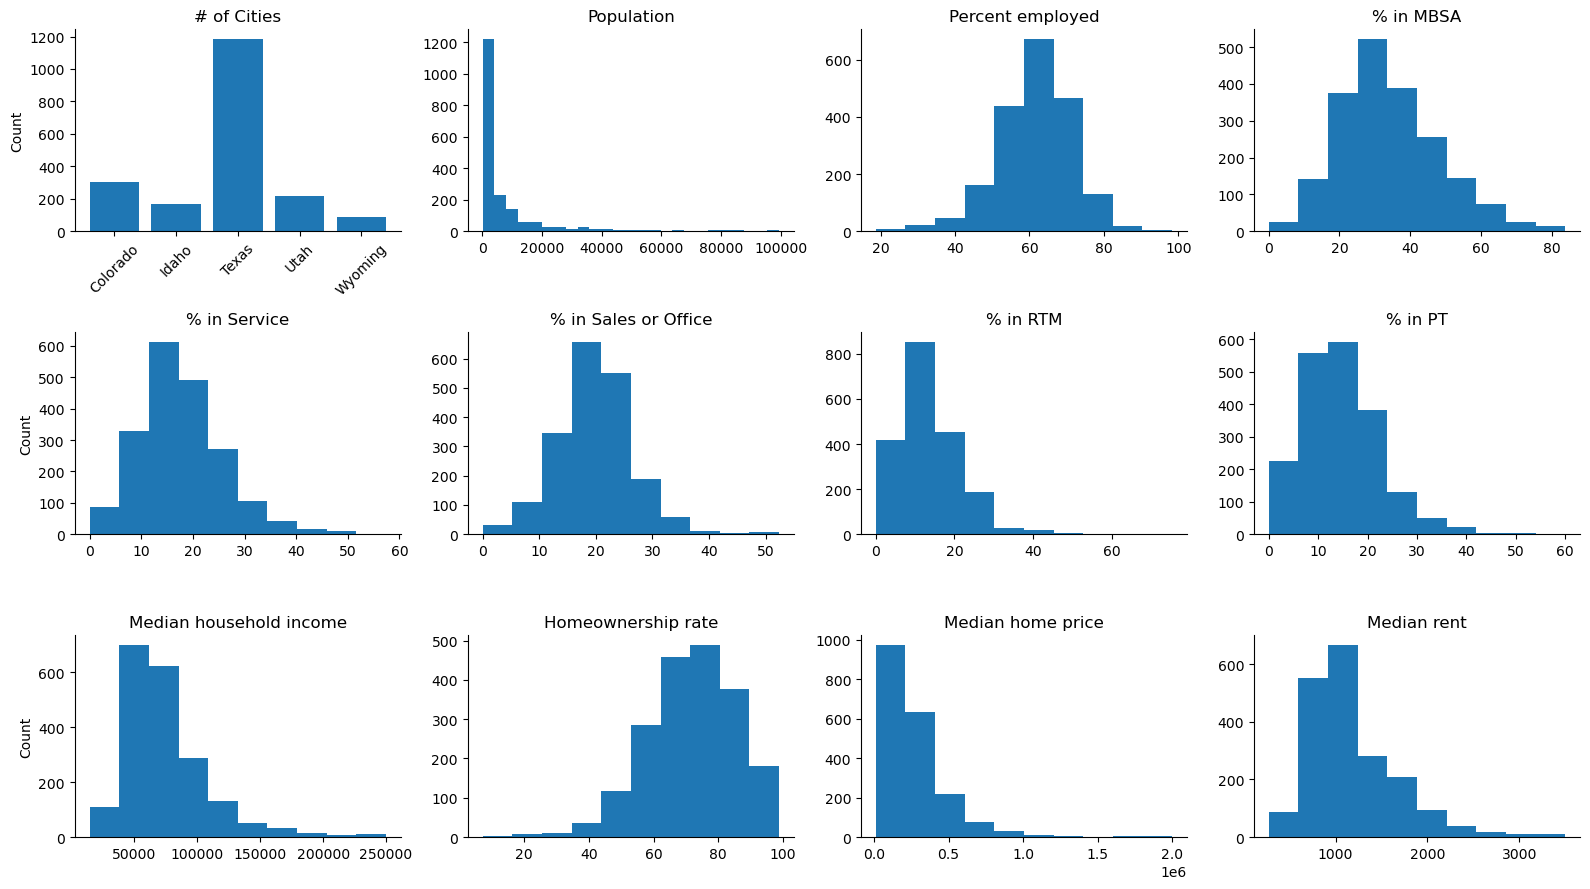

In [3]:
helper.plot_all(df)

Important notes to understand the visualization. MBSA stands for "Management, Business, Science, and Arts". RTM stands for "Natural Resources, Construction, and Maintenance". PT stands for "Production and Transportation". All five subplots titled "% in X" describe the percentage of the employed population working in that field.

Some key takeaways from this visualization:
- Texas dominates the field with over 1,000 cities. Other states don't come close! (Makes sense, Texas has a much greater population)
- The vast majority of cities in the dataset have a tiny population (5,000 or fewer)
- Employment appears somewhat evenly spread between the five domains
- Median household income is concentrated from 50-80,000 dollars a year
- Median home price is concentrated from 0-500,000 thousand dollars
- Median rent has the majority of observations around 1,000 dollars a month, with a tail to the high end

# Preprocessing

In order to get ready for the modeling phase, I need to make a couple decisions.
- Data transformation - I will transform all numerical features (11 total) using the min-max scaler. I need to do this because I will be applying distance-based clustering algorithms (K-means and hierarchical) to my data. Scaling the data will ensure that large features (Median home price) don't dominate some of the other features (the percentages).
- Outliers - At first pass, I will not attempt to remove any outliers from my data. I realize this will cause the vast majority of my observations to have similar values but I am hoping all the outliers (major cities, for example) will be clustered together.
- Importance of factors - I don't know if some factors will carry more weight than others. I could see the median household income, median home price, and median rent making it easy to differentiate between different kinds of cities.

In [4]:
scaled = helper.scale(df)
scaled.head()

,City,State,Population,Percent employed,Occupation (MBSA),Occupation (S),Occupation (SO),Occupation (RCM),Occupation (PT),Median household income,Homeownership rate,Median home price,Median rent
0,"Acres Green, Colorado",Colorado,0.001156,0.678392,0.738663,0.207317,0.238550,0.112882,0.086667,0.429263,0.766376,0.266332,0.740557
1,"Aetna Estates, Colorado",Colorado,0.000490,0.674623,0.149165,0.475610,0.606870,0.225764,0.190000,0.210039,0.295852,0.024222,0.377399
2,"Akron, Colorado",Colorado,0.000709,0.461055,0.483294,0.336237,0.410305,0.175299,0.091667,0.191291,0.689956,0.088694,0.247368
3,"Alamosa, Colorado",Colorado,0.004259,0.541457,0.414081,0.360627,0.505725,0.087649,0.190000,0.138231,0.399563,0.095578,0.188854
4,"Alamosa East, Colorado",Colorado,0.000589,0.624372,0.416468,0.517422,0.341603,0.120850,0.140000,0.128774,0.669214,0.105076,0.256656


# Modeling

My modeling phase is two-fold: I will use K-means to determine an optimal number of clusters using the elbow method, and then I will compare K-Means to hierarchical clustering using the same number of clusters. I will visualize the resulting labels from each method and determine which one I want to use in the application.

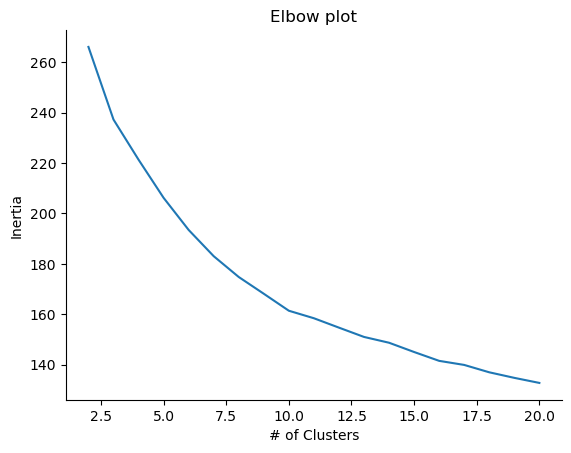

In [5]:
helper.elbow_plot(scaled)

This is not the easiest elbow plot to interpret. There isn't one clear elbow to rule them all. I'm going to treat 10 as the elbow, since it seems a bit sharper than the other angles. I'm going to fit K-means and hierarchical clustering models to my data using n_clusters = 10. I'll add the labels to the original dataset and visualize the results.

In [6]:
labeled = helper.create_labels(scaled, df)
labeled.head()

,City,State,Population,Percent employed,Occupation (MBSA),Occupation (S),Occupation (SO),Occupation (RCM),Occupation (PT),Median household income,Homeownership rate,Median home price,Median rent,KMeans,Hierarchical
0,"Acres Green, Colorado",Colorado,2709.0,72.7,61.9,11.9,12.5,8.5,5.2,115536.0,77.4,540000.0,2663.0,0,3
1,"Aetna Estates, Colorado",Colorado,1177.0,72.4,12.5,27.3,31.8,17.0,11.4,63887.0,34.3,58200.0,1490.0,8,4
2,"Akron, Colorado",Colorado,1681.0,55.4,40.5,19.3,21.5,13.2,5.5,59470.0,70.4,186500.0,1070.0,5,0
3,"Alamosa, Colorado",Colorado,9847.0,61.8,34.7,20.7,26.5,6.6,11.4,46969.0,43.8,200200.0,881.0,8,4
4,"Alamosa East, Colorado",Colorado,1404.0,68.4,34.9,29.7,17.9,9.1,8.4,44741.0,68.5,219100.0,1100.0,3,4


As you can see from the first five observations in the dataset, the two clustering methods returned very different labels. Let's dig into the labels and see if one set of labels does a better job describing the data.

In [7]:
labeled.KMeans.value_counts(), labeled.Hierarchical.value_counts()

(KMeans
 2    312
 8    305
 0    216
 1    206
 4    197
 9    184
 3    171
 5    167
 7    146
 6     63
 Name: count, dtype: int64,
 Hierarchical
 4    784
 0    538
 2    224
 3    141
 1    109
 9     70
 6     33
 5     31
 7     30
 8      7
 Name: count, dtype: int64)

As you can see, KMeans led to a more equal distribution of labels. Hierarchical clustering varies greatly in the number of observations falling under each label. I will investigate some of these labels to see if I like them.

In [8]:
labeled[labeled.Hierarchical == 8]

,City,State,Population,Percent employed,Occupation (MBSA),Occupation (S),Occupation (SO),Occupation (RCM),Occupation (PT),Median household income,Homeownership rate,Median home price,Median rent,KMeans,Hierarchical
74,"Denver, Colorado",Colorado,713734.0,74.3,55.1,13.3,17.8,6.2,7.6,91681.0,49.1,586700.0,1770.0,7,8
519,"Austin, Texas",Texas,967862.0,75.0,57.4,12.6,18.0,5.3,6.7,91461.0,44.4,512700.0,1655.0,7,8
735,"Dallas, Texas",Texas,1299553.0,68.8,40.4,15.4,20.5,10.7,13.1,67760.0,42.4,295300.0,1403.0,7,8
796,"El Paso, Texas",Texas,678147.0,62.4,34.9,21.0,22.6,8.6,13.0,58734.0,60.2,171700.0,1041.0,8,8
830,"Fort Worth, Texas",Texas,941311.0,68.5,38.1,15.8,20.6,9.6,16.0,76602.0,56.7,277300.0,1412.0,7,8
953,"Houston, Texas",Texas,2300419.0,67.1,39.2,17.8,18.8,11.5,12.6,62894.0,42.0,253400.0,1313.0,7,8
1407,"San Antonio, Texas",Texas,1458954.0,65.8,36.0,19.6,22.8,10.1,11.5,62917.0,52.4,219700.0,1258.0,7,8


What do you notice? These are all the major metro areas in the five states. Grouping them together is intuitive. By contrast, KMeans placed a lot of these large cities in cluster 7. Let's take a peek at cluster 7 to see if it makes much sense.

In [9]:
labeled[labeled.KMeans == 7].head()

,City,State,Population,Percent employed,Occupation (MBSA),Occupation (S),Occupation (SO),Occupation (RCM),Occupation (PT),Median household income,Homeownership rate,Median home price,Median rent,KMeans,Hierarchical
6,"Alma, Colorado",Colorado,242.0,72.1,38.6,3.2,20.9,16.5,20.9,52727.0,38.9,370000.0,2083.0,7,1
13,"Aspen, Colorado",Colorado,6862.0,71.4,43.9,24.2,24.2,3.2,4.5,78636.0,59.4,1375000.0,1897.0,7,1
15,"Aurora, Colorado",Colorado,390201.0,71.9,36.7,18.3,20.6,10.6,13.8,84320.0,63.3,444500.0,1759.0,7,0
16,"Avon, Colorado",Colorado,6057.0,88.1,35.2,30.4,23.6,6.6,4.2,85364.0,46.0,689000.0,2132.0,7,1
17,"Basalt, Colorado",Colorado,3995.0,78.3,46.2,23.0,23.4,6.8,0.6,106000.0,58.2,1148100.0,2188.0,7,1


Clearly, cluster 7 varies wildly in terms of things like population. I think the hierarchical clustering does an astronomically better job capturing groups of cities. I'll move forward with these labels for my application. I'm going to explore a couple other labels from the hierarchical method.

In [10]:
labeled[labeled.Hierarchical == 7]

,City,State,Population,Percent employed,Occupation (MBSA),Occupation (S),Occupation (SO),Occupation (RCM),Occupation (PT),Median household income,Homeownership rate,Median home price,Median rent,KMeans,Hierarchical
7,"Altona, Colorado",Colorado,532.0,70.4,75.7,11.0,9.8,3.5,0.0,250001.0,84.6,1168400.0,3501.0,6,7
29,"Bow Mar, Colorado",Colorado,1003.0,52.7,65.6,2.5,21.4,2.0,8.4,233667.0,97.0,1808800.0,3000.0,6,7
116,"Genesee, Colorado",Colorado,3826.0,57.1,67.5,4.3,21.0,3.0,4.2,172692.0,91.4,994700.0,2797.0,6,7
191,"Meridian Village, Colorado",Colorado,2768.0,83.5,73.0,3.7,17.5,0.0,5.8,198707.0,95.8,742800.0,3125.0,6,7
244,"Roxborough Park, Colorado",Colorado,9365.0,68.5,57.3,10.7,21.0,4.1,6.9,167671.0,96.1,648100.0,2936.0,6,7
277,"The Pinery, Colorado",Colorado,11740.0,68.8,60.3,12.4,17.9,3.0,6.3,173889.0,96.7,709800.0,3115.0,6,7
536,"Barton Creek, Texas",Texas,3281.0,44.8,75.7,3.3,17.9,0.8,2.3,193971.0,81.0,1752800.0,1983.0,6,7
550,"Bellaire, Texas",Texas,17116.0,63.0,77.5,5.7,13.0,0.5,3.3,236311.0,87.9,978300.0,2705.0,6,7
554,"Belterra, Texas",Texas,7190.0,71.7,64.8,10.9,16.4,2.0,5.9,211471.0,97.6,658400.0,2789.0,6,7
688,"Colleyville, Texas",Texas,25906.0,63.6,61.7,8.8,18.9,2.6,7.9,203566.0,95.6,718900.0,3194.0,6,7


What ties these places together? These seem like the most expensive places to live on the planet. Median home price in the millions, rent to the moon, and median household income comfortably over 6 digits. The algorithm did a great job grouping these together. I will pause my investigation here to focus on the application.

# Conclusion

A brief recap of what I accomplished in this project:
- Acquired 11 metrics for over 3,000 cities in 5 states of interest (Texas, Colorado, Wyoming, Idaho, Utah)
- Of the records acquired, almost 2,000 were usable
- Visualized the distribution of each feature
- Scaled the features
- Utilized the elbow plot method with K-means clustering to determine the optimal number of clusters
- Compared K-means to agglomerative clustering
- Determined aggomlerative clustering grouped my observations together in an intuitive way!

Agglomerative clustering was the clear winner. I knew it the moment I visualized the first cluster, which was every large city in the dataset. Agglomerative clustering recursively pairs the most similar clusters (or individual observations) in the dataset. I believe this led to the careful association of similar cities. K-means, by contrast, places centroids randomly within the dataset and assigns observations to each centroid. Over time, the centroids are more strategically placed to fit different clusters, but the overall process is less organized. It also operates under the assumption that every cluster is spherical. In our case, with a few outliers (the big cities), hierarchical clustering did a better job capturing them in their own group.